In [1]:
import warnings; warnings.simplefilter('ignore')

import hotspot
import scanpy as sc
import muon as mu
import pandas as pd
# import rpy2
# %load_ext rpy2.ipython

import numpy as np
import mplscience
import anndata2ri

import scipy.stats as stats
import anndata

import new_misc_code as nmc

In [2]:
# Activate the anndata2ri conversion between SingleCellExperiment and AnnData
anndata2ri.activate()

#Loading the rpy2 extension enables cell magic to be used
#This runs R code in jupyter notebook cells
%load_ext rpy2.ipython

sc.settings.verbosity = 3
sc.logging.print_versions()

-----
anndata     0.9.1
scanpy      1.9.3
-----
PIL                         9.5.0
anndata2ri                  1.1
asttokens                   NA
backcall                    0.2.0
cffi                        1.15.1
colorama                    0.4.6
comm                        0.1.3
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.6.7
decorator                   5.1.1
defusedxml                  0.7.1
executing                   1.2.0
h5py                        3.8.0
hotspot                     1.1.1
ipykernel                   6.22.0
ipython_genutils            0.2.0
ipywidgets                  8.0.6
jedi                        0.18.2
jinja2                      3.1.2
joblib                      1.2.0
kiwisolver                  1.4.4
llvmlite                    0.40.0
markupsafe                  2.1.2
matplotlib                  3.7.1
mpl_toolkits                NA
mplscience                  0.0.7
mudata

In [3]:
%%R

suppressPackageStartupMessages(library(Seurat))

SCT_norm <- readRDS("../seurat_clustering/output/SCT_norm.rds")

DefaultAssay(SCT_norm) <- 'SCT'

Idents(SCT_norm) <- "new_clusts"

SCT_norm


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    An object of class Seurat 
34348 features across 142488 samples within 3 assays 
Active assay: SCT (16010 features, 3000 variable features)
 2 other assays present: RNA, integrated
 2 dimensional reductions calculated: pca, umap


In [4]:
%%R -o SCT_sce
#change default assay
DefaultAssay(SCT_norm) <- 'SCT'

#convert the Seurat object to a SingleCellExperiment object
SCT_sce <- as.SingleCellExperiment(SCT_norm)

SCT_sce

class: SingleCellExperiment 
dim: 16010 142488 
metadata(0):
assays(2): X logcounts
rownames(16010): ENSMOCG00000000281 Tecpr2 ... Gzmk Rab44
rowData names(0):
colnames(142488): AAACCTGCAATCTACG-1_1 AAACCTGCATATGGTC-1_1 ...
  TTTGTCATCCGGCACA-1_39 TTTGTCATCGCAAACT-1_39
colData names(23): orig.ident nCount_RNA ... Group ident
reducedDimNames(2): PCA UMAP
mainExpName: NULL
altExpNames(0):


In [5]:
%%R

rm(SCT_norm)
gc()

           [,1]    [,2]       [,3]  [,4]         [,5]       [,6]    [,7]
[1,]    7285120   389.1   14098802   753 2.670300e+03    9340802   498.9
[2,] 1971502588 15041.4 4706520858 35908 8.796093e+12 3954494750 30170.5


In [6]:
#filter genes in single cell experiment object to have min 1 count
sc.pp.filter_genes(SCT_sce, min_counts=1)

filtered out 30 genes that are detected in less than 1 counts


In [ ]:
SCT_sce.layers["counts"] = SCT_sce.X.copy()

# Create the Hotspot object and the neighborhood graph

SCT_sce.layers["counts_csc"] = SCT_sce.layers["counts"].tocsc()
hs = hotspot.Hotspot(
    SCT_sce,
    layer_key="counts_csc",
    model='danb',
    latent_obsm_key="X_pca",
    umi_counts_obs_key="nCount_SCT"
)

hs.create_knn_graph(
    weighted_graph=False, n_neighbors=30,
)

In [ ]:
hs_results = hs.compute_autocorrelations()

hs_results.head(30)

In [ ]:
#group genes into modules
# Select the genes with significant lineage autocorrelation
hs_genes = hs_results.loc[hs_results.FDR < 0.05].sort_values('Z', ascending=False).head(3000).index

# Compute pair-wise local correlations between these genes. this takes ~ 17 hrs with this dataset
lcz = hs.compute_local_correlations(hs_genes)

In [7]:
#create functions to save and load hotspot object
import pickle
def save_obj( obj, name):
    with open( name, 'wb') as f:
        pickle.dump( obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_obj( name):
    with open( name, 'rb') as f:
        return pickle.load(f)

In [ ]:
# #save hotspot object so you don't have to build again
# save_obj( hs, "G:/My Drive/pateiv/seq_analysis/snseq_analysis/Hotspot/new_clusts_noTrh/new_clusts_ncountsct.pkl")

In [8]:
#load in previously saved hotspot object
hs = load_obj( "G:/My Drive/pateiv/seq_analysis/snseq_analysis/Hotspot/new_clusts_noTrh/new_clusts_ncountsct.pkl")

In [9]:
#create modules
modules = hs.create_modules(
    min_gene_threshold=30, core_only=False, fdr_threshold=0.05
)

modules.value_counts()

Module
 2     415
 3     365
 1     359
 7     313
 14    182
 6     143
 5     127
 23    122
 4     103
 8      94
 21     88
 9      86
 17     85
 11     72
 19     70
 10     65
 12     63
 18     55
 20     48
 16     42
 13     38
 22     32
 15     31
-1       2
Name: count, dtype: int64

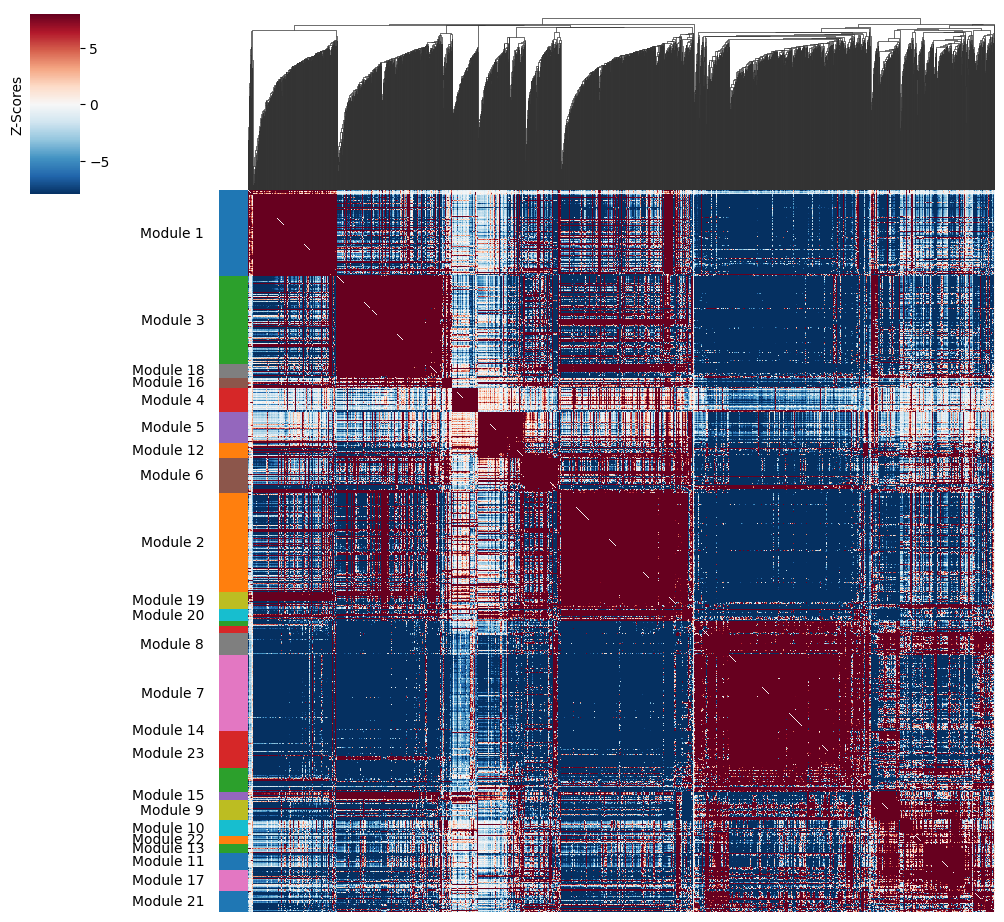

In [10]:
#plot module correlations
hs.plot_local_correlations()

In [11]:
# get all modules in a dataframe
all_mods = hs.results.join(hs.modules)
all_mods.dropna( inplace=True)
# drop non assigned genes
all_mods = all_mods[all_mods['Module']!=-1.0]


# all_mods.to_csv('output/new_clusts_hotspot-gene-modules.csv')


In [12]:
#module "scores"
module_scores = hs.calculate_module_scores()

module_scores.head()

Computing scores for 23 modules...


100%|██████████| 23/23 [02:19<00:00,  6.07s/it]


1         2         3         4         5    
AAACCTGCAATCTACG-1_1  -1.853874 -4.282750 -3.311646 -0.176664 -0.420670  \
AAACCTGCATATGGTC-1_1  -1.975911 -4.304413 -3.286936 -0.281858 -0.396336   
AAACCTGGTCTTTCAT-1_1  48.280218 -2.116395 -1.953506 -0.184057 -0.342648   
AAACCTGGTGTCAATC-1_1  -1.424001 -2.609941 -2.318146 -0.381372  0.079922   
AAACCTGTCAGCGACC-1_1  -2.039947 -4.234350 -3.451809 -0.081031 -0.457323   

                            6         7         8         9         10  ...   
AAACCTGCAATCTACG-1_1 -1.418576  3.896917  1.213929  1.370695 -0.478240  ...  \
AAACCTGCATATGGTC-1_1 -1.374499  6.058199 -1.420297 -0.965380 -0.444638  ...   
AAACCTGGTCTTTCAT-1_1 -0.435133 -7.381414 -4.318873 -2.277556  0.366828  ...   
AAACCTGGTGTCAATC-1_1  0.066060 -4.878637 -1.673548 -0.375651 -0.072351  ...   
AAACCTGTCAGCGACC-1_1 -1.308644  6.145695 -0.862832 -2.448839 -0.454328  ...   

                            14        15        16        17        18   
AAACCTGCAATCTACG-1_1  2.141519 -0.377764 -0.431093 -0.417208 -0.869468  \
AAACCTGCATATGGTC-1_1  4.055981 -1.394587 -0.717857 -1.028338 -1.097970   
AAACCTGGTCTTTCAT-1_1 -3.431041  0.078991  0.042173 -0.943443 -0.297598   
AAACCTGGTGTCAATC-1_1 -2.281227  0.461099 -0.069886  0.946302  0.437041   
AAACCTGTCAGCGACC-1_1  3.117229 -1.756761 -0.571998 -1.083901 -1.056784   

                            19        20        21        22        23  
AAACCTGCAATCTACG-1_1 -1.425137 -1.399837 -0.775589 -0.235051  0.168041  
AAACCTGCATATGGTC-1_1 -1.314530 -0.504743 -1.188317 -0.392440  0.515614  
AAACCTGGTCTTTCAT-1_1  3.225190  0.364152 -1.541128 -0.390173 -1.118755  
AAACCTGGTGTCAATC-1_1  1.645365  3.014343 -0.108556 -0.360980  0.469411  
AAACCTGTCAGCGACC-1_1 -1.227700  0.487602 -1.073601 -0.364472  1.855762  

[5 rows x 23 columns]

In [13]:
#for raw module scores
module_cols = []
for c in module_scores.columns:
    key = f"Module {c}"
    SCT_sce.obs[key] = module_scores[c]
    module_cols.append(key)
    

meta NOT subset; don't know how to subset; dropped


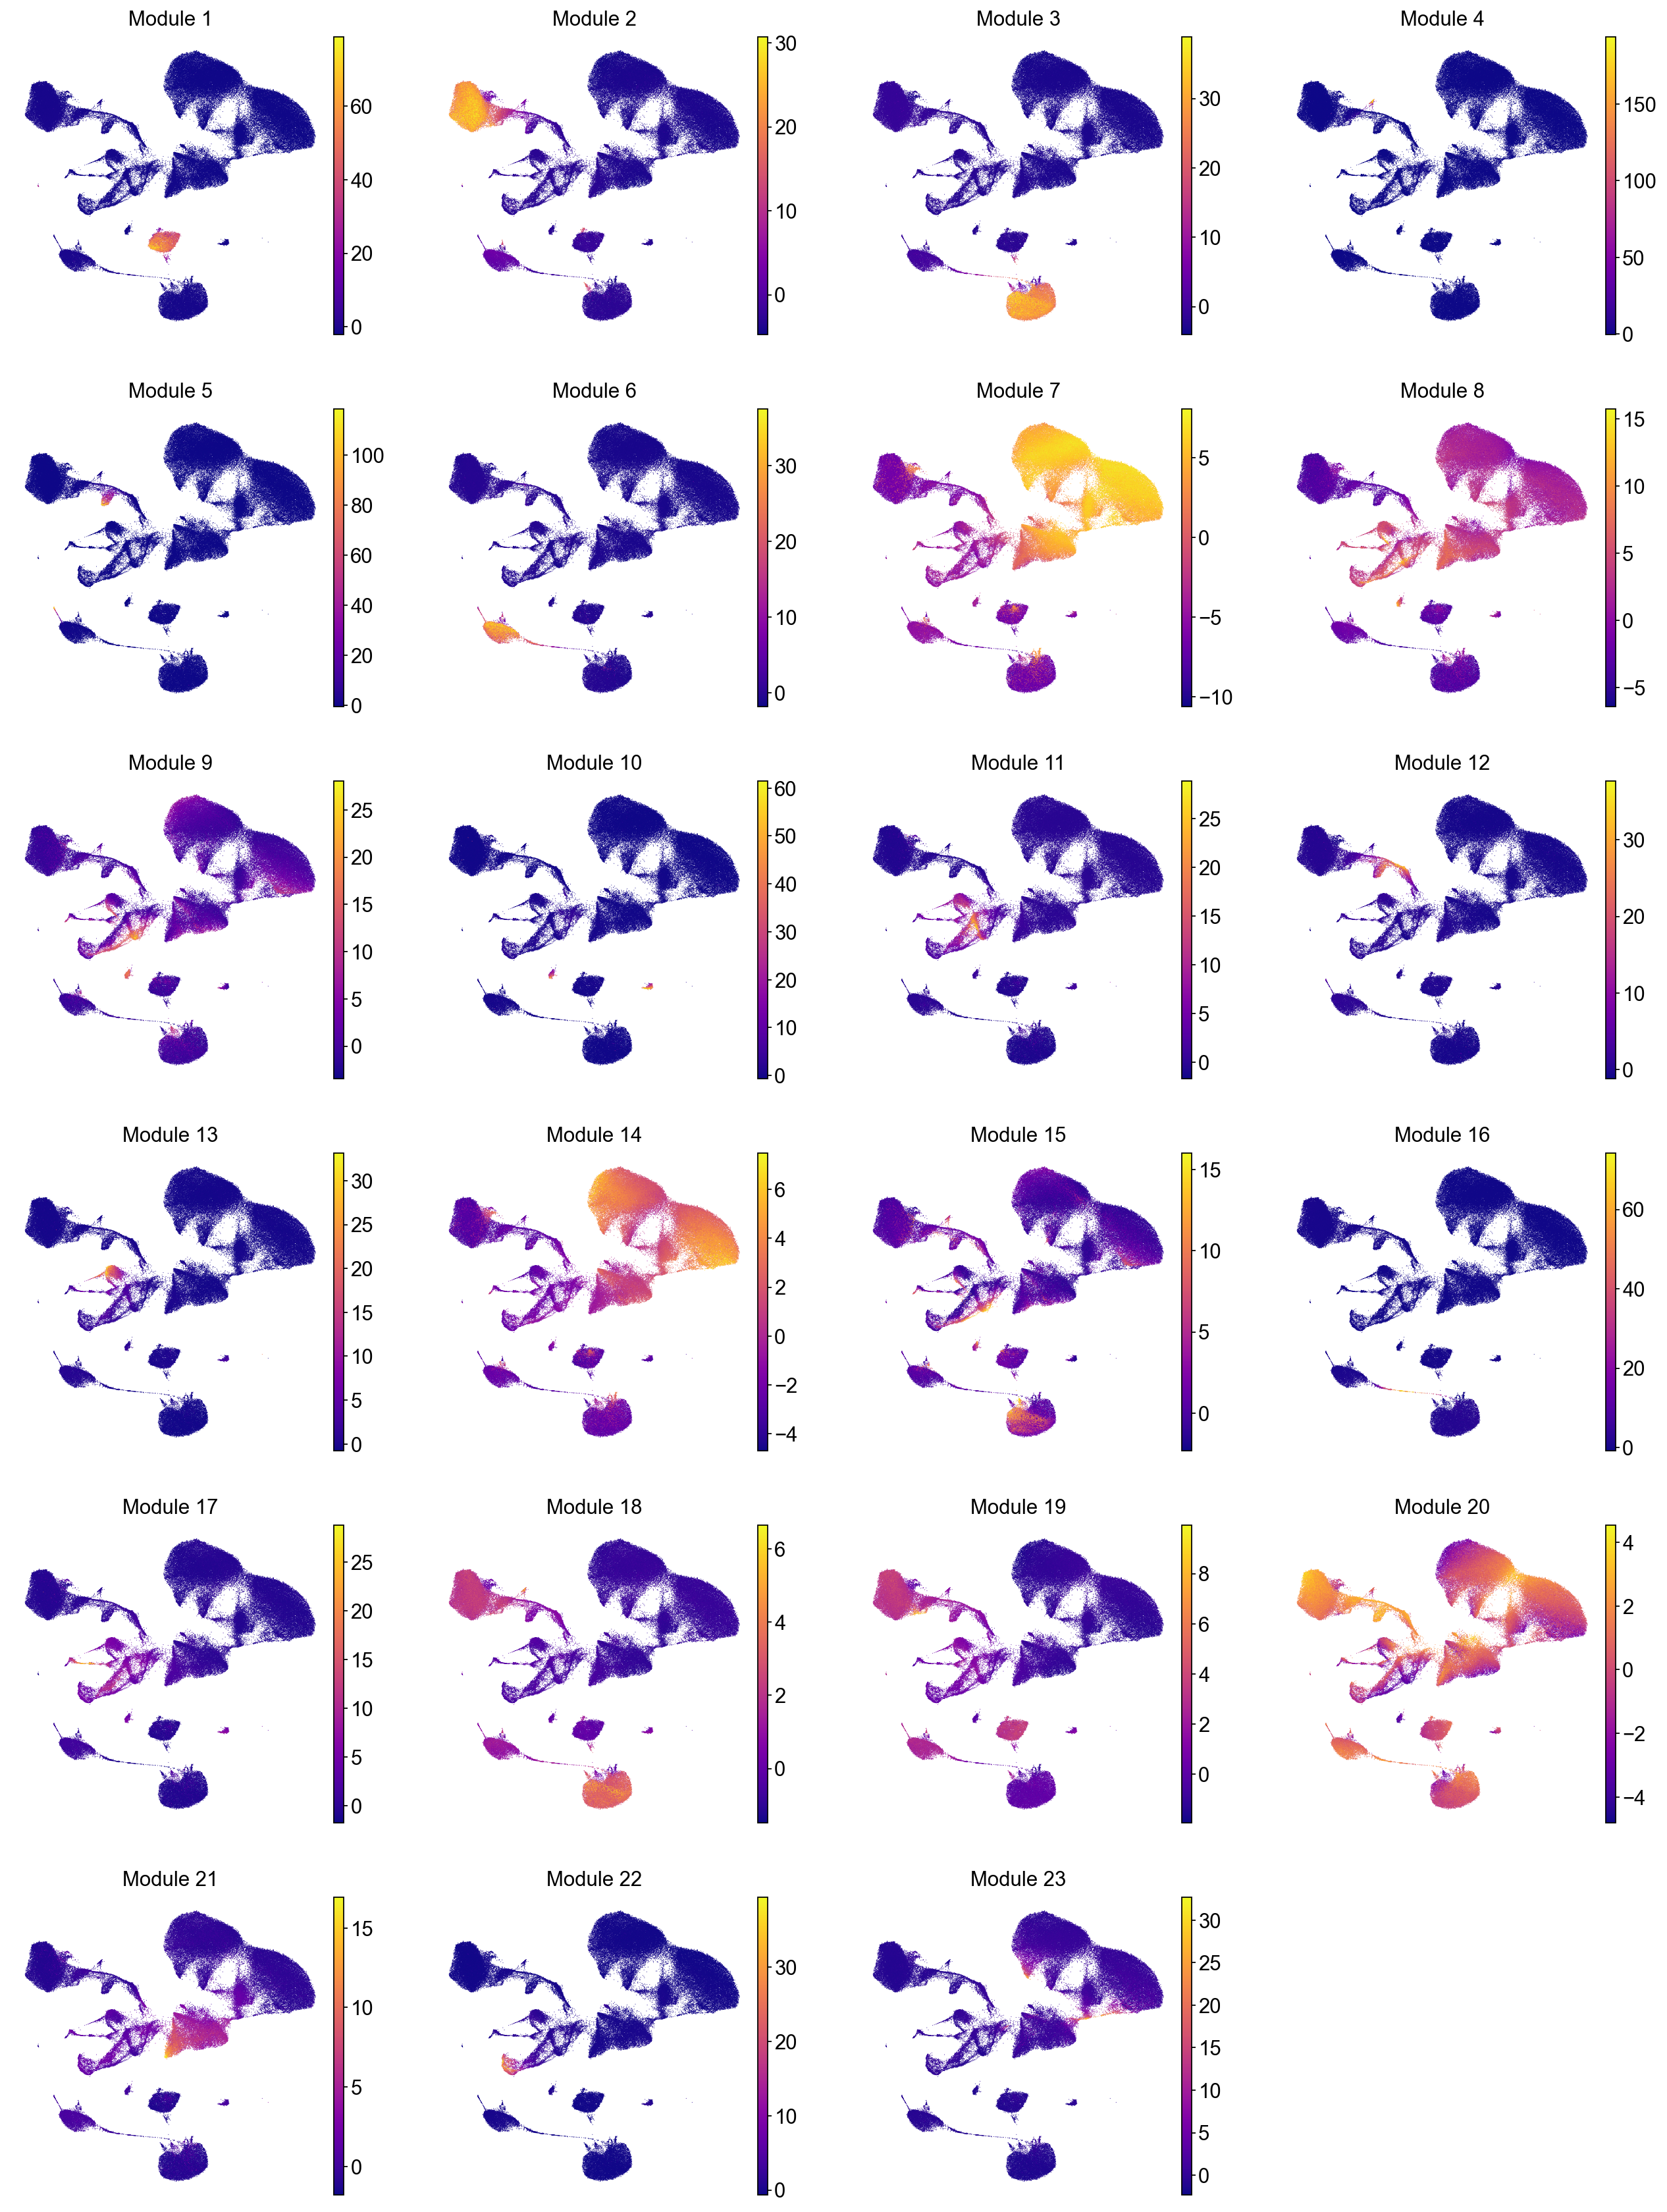

In [14]:
#plot module scores on top of UMAP for comparison
import matplotlib as mpl

# mplscience.set_style(reset_current=True)
cmap = mpl.colormaps['plasma']
with mplscience.style_context():
    sc.set_figure_params(format = "pdf", vector_friendly=True, dpi_save = 300) #vector friendly false does not rasterize
    sc.pl.umap(SCT_sce, color=module_cols, cmap=cmap, frameon=False, 
               save = 'umaps_modules_raster.pdf'
               ) #, vmin=-2, vmax=2

## to print each UMAP separately
# for mod in module_scores.columns:
#     print(mod)
#     with mplscience.style_context():
#         sc.set_figure_params(format = "pdf", vector_friendly=True, dpi_save = 300) #, figsize = [8, 8]
#         sc.pl.umap(SCT_sce, color=f"Module {mod}", cmap=cmap, frameon=False,
#                    save = f"Module_{mod}_umap_raster.pdf"
#                    )


In [15]:
#import metadata
metadata = pd.read_csv('../../docs/seq_beh_metadata.csv')

anis = np.array(metadata['animal'].apply(str))
anis

metadata

sample_id  animal       pair sex pair_type SS_OS color  age preg   
0   NAc_4905_F    4905  4905x4975   F        FM    OS     O  170    N  \
1   NAc_4975_M    4975  4905x4975   M        FM    OS     B  152  NaN   
2   NAc_4918_F    4918  4918x4967   F        FM    OS     O  157    Y   
3   NAc_4967_M    4967  4918x4967   M        FM    OS     B  147  NaN   
4   NAc_4893_M    4893  4893x4910   M        MM    SS     O  118  NaN   
5   NAc_4910_M    4910  4893x4910   M        MM    SS     B  113  NaN   
6   NAc_4921_F    4921  4921x4909   F        FM    OS     O  107    Y   
7   NAc_4909_M    4909  4921x4909   M        FM    OS     B  113  NaN   
8   NAc_4968_F    4968  4968x4931   F        FM    OS     O  147    N   
9   NAc_4931_M    4931  4968x4931   M        FM    OS     B  154  NaN   
10  NAc_4907_F    4907  4907x5228   F        FF    SS     O  170    N   
11  NAc_5228_F    5228  4907x5228   F        FF    SS     B   93    N   
12  NAc_5021_F    5021  5021x5204   F        FM    OS     O  138    Y   
13  NAc_5204_M    5204  5021x5204   M        FM    OS     B  100  NaN   
14  NAc_4940_F    4940  4940x4916   F        FM    OS     O  153    Y   
15  NAc_4916_M    4916  4940x4916   M        FM    OS     B  157  NaN   
16  NAc_4958_F    4958  4958x4901   F        FF    SS     O   99    N   
17  NAc_4901_F    4901  4958x4901   F        FF    SS     B  114    N   
18  NAc_4960_F    4960  4960x4928   F        FM    OS     O   99    Y   
19  NAc_4928_M    4928  4960x4928   M        FM    OS     B  106  NaN   
20  NAc_5225_F    5225  5225x5121   F        FM    OS     O   93    Y   
21  NAc_5121_M    5121  5225x5121   M        FM    OS     B  115  NaN   
22  NAc_4917_M    4917  4917x4932   M        MM    SS     O  157  NaN   
23  NAc_4932_M    4932  4917x4932   M        MM    SS     B  154  NaN   
24  NAc_5209_M    5209  5209x4974   M        MM    SS     O  100  NaN   
25  NAc_4974_M    4974  5209x4974   M        MM    SS     B  152  NaN   
26  NAc_4896_F    4896  4896x4894   F        FM    OS     O  114    Y   
27  NAc_4894_M    4894  4896x4894   M        FM    OS     B  118  NaN   
28  NAc_5023_F    5023  5023x4963   F        FF    SS     O  138    N   
29  NAc_4963_F    4963  5023x4963   F        FF    SS     B  155    N   
30  NAc_5227_F    5227  5227x5122   F        FM    OS     O   93    N   
31  NAc_5122_M    5122  5227x5122   M        FM    OS     B  115  NaN   
32  NAc_4898_F    4898  4898x4920   F        FF    SS     O  114    N   
33  NAc_4920_F    4920  4898x4920   F        FF    SS     B  107    N   
34  NAc_4976_M    4976  4976x5124   M        MM    SS     O  152  NaN   
35  NAc_5124_M    5124  4976x5124   M        MM    SS     B  115  NaN   
36  NAc_4908_M    4908  4908x4970   M        MM    SS     O  162  NaN   
37  NAc_4970_M    4970  4908x4970   M        MM    SS     B  147  NaN   
38  NAc_4947_F    4947   4947x923   F        FM    OS     O  153    Y   
39   NAc_923_M     923   4947x923   M        FM    OS     B  161  NaN   

    seq_cohort  beh_cohort  seq_conc  animal_order  ST_phuddle  LT_phuddle   
0            1           4      1580             1     3978.58     3943.81  \
1            1           4      1750             2     6817.05     5851.85   
2            1           3      1630             3     2916.82     3838.97   
3            1           3       480             4     4590.46     4198.47   
4            1           2      1450             5     5533.43     4350.25   
5            1           2       730             6     4137.94     2443.94   
6            2           2       770             7     3909.31     6170.30   
7            2           2      1610             8     3230.26     3759.76   
8            2           3       790             9     7042.98     6713.68   
9            2           3      1280            10     2771.04     5089.36   
10           2           4       540            11     2608.68     2508.41   
11           2           4       320            12     5096.30     4631.93 

In [18]:
#average module gene expression by animal
gene_names = SCT_sce.var_names.values


csme_all = pd.DataFrame([])

for ani in anis:
    adata_itr1 = SCT_sce[SCT_sce.obs['Ani']==ani]

    ind_nm = f"{ani}"
    # loop through modules
    for mod_itr in all_mods['Module'].unique():
        if( int(mod_itr)==-1):
            continue
        mod_gene_mk = all_mods['Module']==mod_itr
        mod_genes = all_mods.index.values[mod_gene_mk]
        adata_gene_mk = np.array( nmc.member_test( gene_names, mod_genes))
        gene_csr = adata_itr1[:,adata_gene_mk].layers['logcounts']
        if( gene_csr.sum(0).sum()==0.0):
            print( f"nothing in {ind_nm}")
            csme_all.loc[ind_nm,f"Module-{str(int(mod_itr))}"] = 0.0
        else:
            gene_mean = gene_csr.mean(0)
            csme_all.loc[ind_nm,f"Module-{str(int(mod_itr))}"] = np.mean( [gene_mean])
                
                
csme_all

nothing in 4967
nothing in 4967
nothing in 4967
nothing in 4967
nothing in 4967
nothing in 4967
nothing in 4967
nothing in 4967
nothing in 4967
nothing in 4967
nothing in 4967
nothing in 4967
nothing in 4967
nothing in 4967
nothing in 4967
nothing in 4967
nothing in 4967
nothing in 4967
nothing in 4967
nothing in 4967
nothing in 4967
nothing in 4967
nothing in 4967


Module-1  Module-3  Module-2  Module-6  Module-12  Module-21  Module-19   
4905  0.053085  0.117524  0.112418  0.095206   0.082926   0.061205   0.098717  \
4975  0.042101  0.100503  0.103652  0.103649   0.074450   0.078671   0.093700   
4918  0.043189  0.090238  0.110857  0.101706   0.079855   0.067967   0.094871   
4967  0.000000  0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
4893  0.035612  0.085241  0.103546  0.098327   0.073657   0.066243   0.090525   
4910  0.034573  0.087544  0.084195  0.101384   0.064995   0.068982   0.076150   
4921  0.036901  0.088423  0.099843  0.113939   0.068854   0.071803   0.083354   
4909  0.052424  0.121452  0.112679  0.116636   0.079288   0.076898   0.093868   
4968  0.045201  0.096706  0.099197  0.118479   0.070816   0.082669   0.091325   
4931  0.048716  0.117474  0.108020  0.118759   0.075983   0.083403   0.095091   
4907  0.051696  0.107941  0.103600  0.107080   0.081076   0.083361   0.092047   
5228  0.043483  0.113478  0.101927  0.102370   0.083023   0.062647   0.089193   
5021  0.039562  0.100482  0.095112  0.109759   0.075589   0.071425   0.086743   
5204  0.039877  0.089751  0.097265  0.109315   0.069145   0.074216   0.090926   
4940  0.050014  0.119361  0.104792  0.111552   0.096388   0.063901   0.090749   
4916  0.048695  0.105578  0.110210  0.108049   0.075509   0.061279   0.095209   
4958  0.052178  0.125296  0.122141  0.115656   0.114518   0.063807   0.103268   
4901  0.050660  0.105674  0.113787  0.106871   0.077309   0.075488   0.096813   
4960  0.045506  0.094693  0.099012  0.120557   0.069318   0.076004   0.087047   
4928  0.039534  0.090172  0.104677  0.108109   0.074732   0.073022   0.089157   
5225  0.040039  0.096921  0.095978  0.129050   0.069906   0.073688   0.082629   
5121  0.048466  0.109616  0.121176  0.117609   0.080879   0.069799   0.099951   
4917  0.040626  0.089886  0.097639  0.119623   0.071303   0.076260   0.087691   
4932  0.048629  0.117802  0.105168  0.119641   0.077617   0.064854   0.090428   
5209  0.046939  0.100228  0.099316  0.120322   0.074827   0.089541   0.091650   
4974  0.034018  0.082769  0.088781  0.113611   0.063500   0.072851   0.080654   
4896  0.040370  0.094153  0.096224  0.120274   0.075561   0.072110   0.082228   
4894  0.037411  0.086868  0.090134  0.117040   0.074916   0.080836   0.080093   
5023  0.040361  0.094081  0.097734  0.124196   0.073389   0.077877   0.084551   
4963  0.055554  0.120988  0.120281  0.123751   0.077931   0.067757   0.099607   
5227  0.040868  0.104657  0.109018  0.125307   0.071591   0.075537   0.090847   
5122  0.042218  0.108790  0.097721  0.117106   0.074713   0.070322   0.086299   
4898  0.051442  0.105563  0.113978  0.120030   0.078701   0.070334   0.093804   
4920  0.048811  0.120988  0.116885  0.121761   0.095336   0.064809   0.092253   
4976  0.049466  0.119060  0.109089  0.119710   0.072042   0.066368   0.089421   
5124  0.054000  0.127935  0.125432  0.119700   0.084666   0.063139   0.098952   
4908  0.042326  0.113625  0.114063  0.108348   0.073454   0.063379   0.091707   
4970  0.044930  0.113635  0.104971  0.112202   0.083491   0.076792   0.091141   
4947  0.044888  0.110722  0.104312  0.115144   0.072393   0.067566   0.090472   
923   0.040781  0.094593  0.104736  0.123133   0.067782   0.073909   0.084408   

      Module-5  Module-14  Module-23  ...  Module-17  Module-4  Module-8   
4905  0.011332   0.156777   0.169573  ...   0.047965  0.006546  0.241227  \
4975  0.009937   0.179645   0.194338  ...   0.057293  0.005087  0.318525   
4918  0.009965   0.158330   0.190691  ...   0.062173  0.006636  0.307123   
4967  0.000000   0.000000   0.000000  ...   0.000000  0.000000  0.000000   
4893  0.009651   0.144852   0.177775  ...   0.058597  0.006042  0.294246   
4910  0.008385   0.177677   0.171019  ...   0.056190  0.005539  0.368286   
4921  0.009099   0.174790   0.188921  ...   0.053762  0.004460  0.367234   
4909  0.011877   0.171030   0.173526  ...   0.056163  0.005766  0.357707   


In [ ]:
csme_all.to_csv('docs/ani_mod_scores_allcells_lognorm_counts.csv')